# Intro

Neurological disorders, including neurodegenerative diseases such as Alzheimer's and brain tumors, are a leading cause of death and disability across the globe. However, it is hard to quantify how well these deadly disorders respond to treatment. One accepted method is to review neuronal cells via light microscopy, which is both accessible and non-invasive. Unfortunately, segmenting individual neuronal cells in microscopic images can be challenging and time-intensive. Accurate instance segmentation of these cells—with the help of computer vision—could lead to new and effective drug discoveries to treat the millions of people with these disorders.

Current solutions have limited accuracy for neuronal cells in particular. In internal studies to develop cell instance segmentation models, the neuroblastoma cell line SH-SY5Y consistently exhibits the lowest precision scores out of eight different cancer cell types tested. This could be because neuronal cells have a very unique, irregular and concave morphology associated with them, making them challenging to segment with commonly used mask heads.

# Files

__train.csv__ - IDs and masks for all training objects. None of this metadata is provided for the test set.
- __id__ - unique identifier for object
- __annotation__ - run length encoded pixels for the identified neuronal cell
- __width__ - source image width
- __height__ - source image height
- __cell_type__ - the cell line
- __plate_time__ - time plate was created
- __sample_date__ - date sample was created
- __sample_id__ - sample identifier
- __elapsed_timedelta__ - time since first image taken of sample

__sample_submission.csv__ - a sample submission file in the correct format

__train__ - train images in PNG format

__test__ - test images in PNG format. Only a few test set images are available for download; the remainder can only be accessed by your notebooks when you submit.

__train_semi_supervised__ - unlabeled images offered in case you want to use additional data for a semi-supervised approach.

# Libs

In [52]:
%%time

# for data process
import os
import cv2
import pandas as pd
import numpy as np

# for plots and views
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from PIL import ImageDraw

# for builds nn
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

# additional
from IPython import display
import warnings
warnings.filterwarnings("ignore")

Wall time: 253 ms
Parser   : 401 ms


# Init paths

In [2]:
# images
PATH_TO_TRAIN_DIR = "./data/train/"
PATH_TO_TEST_DIR = "./data/test/"

# csv
PATH_TO_TRAIN_CSV = "./data/train.csv"

# EDA

## csv

View info about images and their masks from csv dataframe

In [3]:
train_df = pd.read_csv(PATH_TO_TRAIN_CSV)
train_df.sample(5)

id                                         annotation  width  \
33212  78440cb4b47d  338102 6 338806 6 339510 6 340215 5 340919 5 3...    704   
38840  878db7a5ab51  73867 3 74571 4 75275 5 75980 10 76684 12 7738...    704   
34071  7ad870da5a63  302671 7 303374 10 304077 13 304780 16 305484 ...    704   
46220  9f1c2cfc936f  55223 7 55927 11 56629 16 57331 20 58034 25 58...    704   
54586  b307d66eb656  338863 9 339566 11 340270 11 340974 10 341678 ...    704   

       height cell_type plate_time sample_date  \
33212     520    shsy5y  11h30m00s  2019-06-14   
38840     520    shsy5y  11h30m00s  2019-06-15   
34071     520      cort  19h30m00s  2020-11-04   
46220     520    shsy5y  11h30m00s  2019-06-15   
54586     520    shsy5y  11h30m00s  2019-06-14   

                                sample_id elapsed_timedelta  
33212   shsy5y[diff]_D4-4_Vessel-714_Ph_1   0 days 11:30:00  
38840   shsy5y[diff]_D9-4_Vessel-714_Ph_3   0 days 11:30:00  
34071  cort[oka-low]_H6-4_Vessel-377_Ph_1   0 days 19:30:00  
46220   shsy5y[diff]_E5-1_Vessel-714_Ph_1   0 days 11:30:00  
54586   shsy5y[diff]_D3-4_Vessel-714_Ph_3   0 days 11:30:00

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


In [5]:
train_df.describe()

width   height
count  73585.0  73585.0
mean     704.0    520.0
std        0.0      0.0
min      704.0    520.0
25%      704.0    520.0
50%      704.0    520.0
75%      704.0    520.0
max      704.0    520.0

## images

Let's load the images and look at them

In [6]:
def get_full_path_list(path: str, names: list = []) -> list:
    """
    Get path and create full path to png
    
    params: 
        path:  path to dir whith files
        names: list of png names
        
    return: list whith full paths to imgs
    """
    if len(names) > 0:
        paths_list = [path + name + ".png" for name in names]
    else:
        paths_list = [path + file for file in os.listdir(path)]
        
    return paths_list

def get_img(path: str) -> np.ndarray:
    """
    Get image as an array
    
    params:
        path: full path to image
    
    return: image as array
    """
    img = cv2.imread(path)
    return img

def view_examples(imgs: np.ndarray) -> tuple:
    """
    draw first of three examples of images
    
    params:
        imgs: array of imgs
        
    return: figure, axis of subplot
    """
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    for i in range(3):
        ax[i].imshow(imgs[i])
    
    return fig, ax

### train

train file count: 606
dims of images: (606, 520, 704, 3)


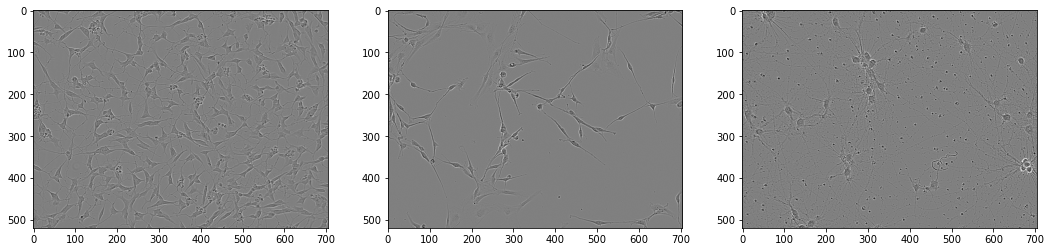

In [7]:
# get ids of images
train_image_ids = train_df["id"].unique() 

# get paths to images
paths_to_training_imgs = get_full_path_list(PATH_TO_TRAIN_DIR, train_image_ids)
print("train file count:", len(paths_to_training_imgs))

# get images
train_imgs = np.array([get_img(path) for path in paths_to_training_imgs], dtype=np.uint)
print("dims of images:", train_imgs.shape)

# view images
view_examples(train_imgs)
plt.show()

### test

train file count: 3
dims of images: (3, 520, 704, 3)


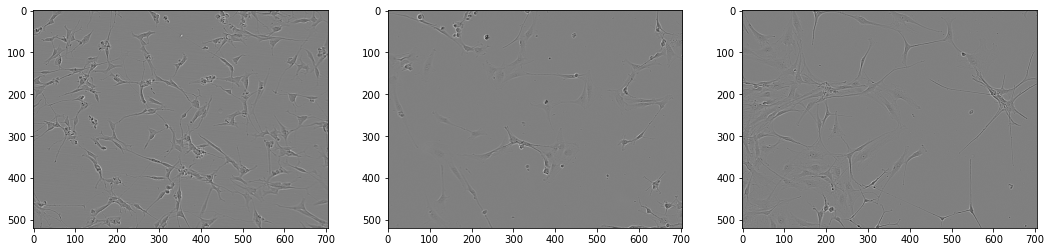

In [8]:
# get paths to images
paths_to_testing_imgs = get_full_path_list(PATH_TO_TEST_DIR)
print("train file count:", len(paths_to_testing_imgs))

# get images
test_imgs = np.array([get_img(path) for path in paths_to_testing_imgs], dtype=np.uint)
print("dims of images:", test_imgs.shape)

# view images
view_examples(test_imgs)
plt.show()

### cell types

We see some __cell types__, let's look at their distribution

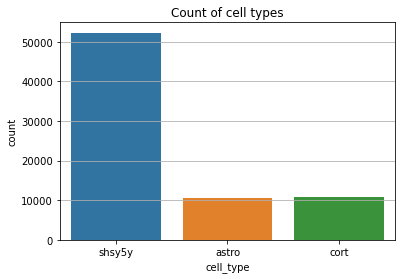

In [9]:
plt.title("Count of cell types")
sns.countplot(train_df['cell_type'])
plt.grid(axis="y")

Only three of __cell types__, lets look at them images

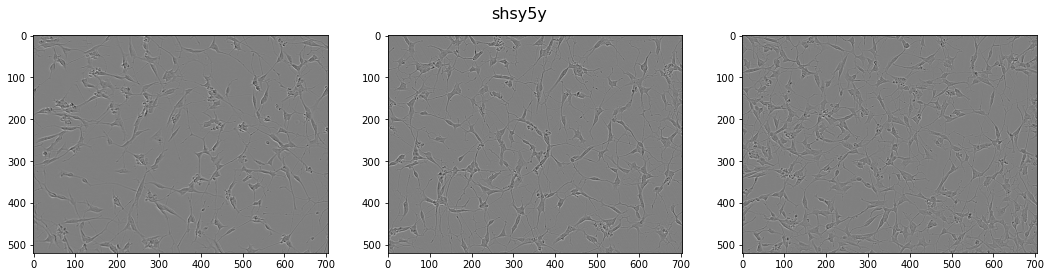

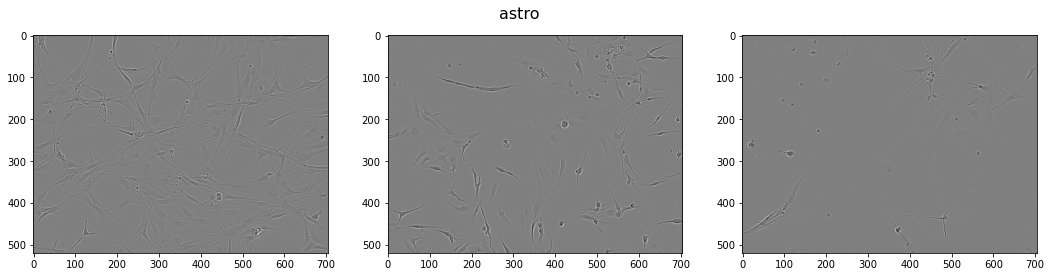

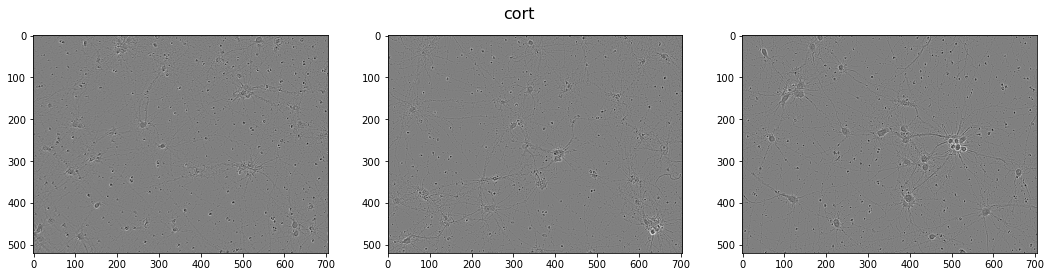

In [10]:
cell_types = train_df["cell_type"].unique()

for cell_type in cell_types:
    imgs = train_df[train_df["cell_type"] == cell_type]
    imgs = imgs["id"].sample(3).unique()
    imgs = np.array([get_img(PATH_TO_TRAIN_DIR + idx + ".png") for idx in imgs], dtype=np.uint)
    
    fig, ax = view_examples(imgs)
    fig.suptitle(cell_type, fontsize=16)

## mask

Now let's see at the masks

In [11]:
WIDTH, HEIGHT = train_df.loc[0, ["width", "height"]]
WIDTH, HEIGHT

(704, 520)

In [12]:
def get_mask(ann: str) -> np.ndarray:
    """Takes annotation and return mask
    
    params:
        ann: annotation of image
        
    return: mask of image"""
    
    mask = np.zeros([HEIGHT * WIDTH])
    
    ann = np.array(ann.split(), dtype=np.uint).reshape(-1, 2)
    ann[:, 0] -= 1
    
    for row in ann:
        
        row = np.arange(row[0], row[0] + row[1], dtype=np.uint)
        mask[row] = 1
    
    mask = mask.reshape([HEIGHT, WIDTH])
        
    return mask

def get_box(mask: np.ndarray) -> np.ndarray:
    """Takes mask and returning box around of mask
    
    params:
        mask: array of mask
        
    return: box around mask"""
    
    box = np.zeros([HEIGHT, WIDTH])
    
    y, x = np.nonzero(mask)
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    box[ymin, xmin : xmax] = 1
    box[ymax, xmin : xmax] = 1
    box[ymin : ymax, xmin] = 1
    box[ymin : ymax, xmax] = 1
    
    return box

def get_mask_box(img_id: str, save=False, load=False) -> np.ndarray:
    """Takes index of image and return array with 3 layers where 1 layer is mask, 2 layer is box
    
    params:
        img_id: index of image
        save:   write image to path ./data/train_mask_box/name.png
        load:   get image from path ./data/train_mask_box/name.png
        
    return: array with mask and box"""
    
    if load:
        mask_box = cv2.imread(f"./data/train_mask_box/{img_id}.png")
        
    else:
        mask_box = np.zeros([HEIGHT, WIDTH, 3], dtype=np.uint)
        img_annotation = train_df.loc[train_df["id"] == img_id, "annotation"]

        for part in img_annotation:

            mask = get_mask(part)
            idx = mask.nonzero()
            mask_box[idx[0], idx[1], 0] = 1

            box = get_box(mask)
            idx = box.nonzero()
            mask_box[idx[0], idx[1], 1] = 1
    
        if save:
            cv2.imwrite(f"./data/train_mask_box/{img_id}.png", (mask_box * 255).astype(np.uint8))
        
    return mask_box

dims of images: (606, 520, 704, 3)
min: 0 / max: 255
Wall time: 3.93 s


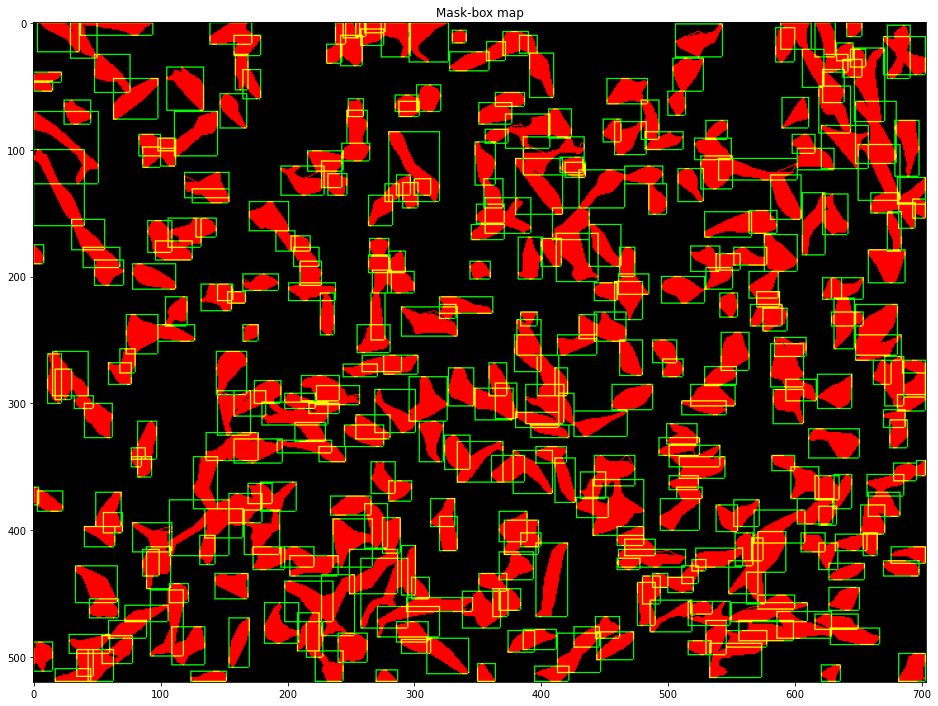

In [13]:
%%time

train_masks_box = np.array([get_mask_box(img_id, load=True) for img_id in train_image_ids])

print("dims of images:", train_masks_box.shape)
print(f"min: {train_masks_box.min()} / max: {train_masks_box.max()}")

plt.figure(figsize=(16, 16))
plt.title("Mask-box map")
plt.imshow(train_masks_box[0])

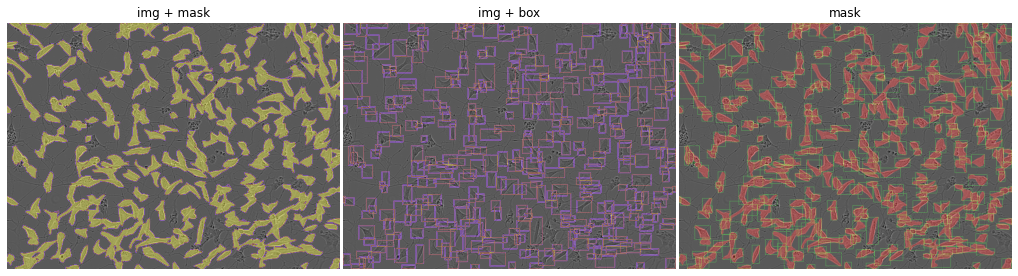

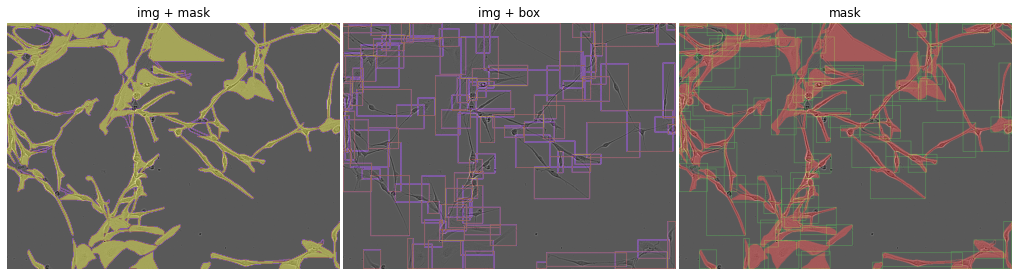

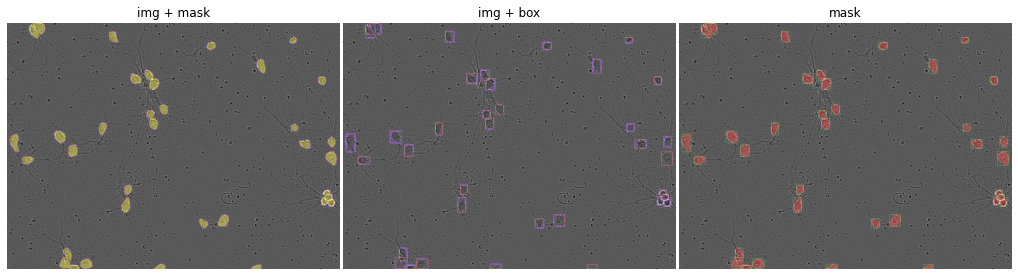

In [14]:
def draw_subimg(axid, img, mask=[], name=None, alpha=0.1):
    if name:
        ax[axid].set_title(name)
        
    ax[axid].imshow(img, cmap="binary")
    if len(mask) > 0:
        ax[axid].imshow(mask, cmap="gnuplot", alpha=alpha)
        
    ax[axid].axis("off")

for i in range(3):

    fig, ax = plt.subplots(1, 3, figsize=(18, 10))

    draw_subimg(0, train_imgs[i], train_masks_box[i, ..., 0], name="img + mask", alpha=0.3)
    draw_subimg(1, train_imgs[i], train_masks_box[i, ..., 1], name="img + box", alpha=0.3)
    draw_subimg(2, train_imgs[i], train_masks_box[i], name="mask", alpha=0.3)

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

# Preprocess data

Since the images are too large, spliting them into smaller ones, thus reducing the load on the GPU on each training iteration and increasing the sample.

In [15]:
def split_img(img: np.ndarray, 
              size: int = 128, 
              excess: bool = True) -> np.ndarray:
    """get image and split it on size
    
    params:
        img:  original image
        size: size of results"""
    
    h_offsets = HEIGHT // size
    w_offsets = WIDTH // size
    
    if excess:
        h_excess = HEIGHT % size
        w_excess = WIDTH % size
    
        h_offsets += 1 if h_excess else 0
        w_offsets += 1 if h_excess else 0
    
    arr_imgs = []
    for i in range(h_offsets):
        for j in range(w_offsets):
            
            w_start, w_end = j*size, (j+1)*size
            
            if j == w_offsets-1 and excess:
                w_start += w_excess - size
                w_end += w_excess - size
            
            h_start, h_end = i*size, (i+1)*size
            
            if i == h_offsets-1 and excess:
                h_start += h_excess - size
                h_end += h_excess - size
            
            piese = img[h_start: h_end,
                        w_start: w_end]
        
            arr_imgs.append(piese)
    
    arr_imgs = np.array(arr_imgs)
    
    return arr_imgs

def view_spliting_imgs(pieces: np.ndarray, 
                       masks: np.ndarray = np.array([]), 
                       excess: bool = True) -> None:
    """Show original image from its parts in the form of a grid
    
    params:
        pieces: array of images that are part of a original image
        masks:  array of masks that are part of a original mask
        excess: allocate space for excesses"""
    
    size = pieces.shape[1] # 128
    
    cols = WIDTH // size
    rows = HEIGHT // size
    
    if excess:
        w_excess = WIDTH % size
        h_excess = HEIGHT % size
    
        cols += 1 if w_excess else 0
        rows += 1 if h_excess else 0

    fig, ax = plt.subplots(rows, cols, figsize=(12, 10))

    for i in range(rows):
        for j in range(cols):

            idx = j + i*cols

            ax[i, j].imshow(pieces[idx], cmap="binary")
            if len(masks) > 0:
                ax[i, j].imshow(masks[idx], cmap="gnuplot", alpha=0.3)
            ax[i, j].axis("off")

    plt.subplots_adjust(wspace=0.01, hspace=0.01)

Now lowering reserved memory, for load all images in dataset

train_imgs shape: (12120, 128, 128, 1) type: uint16
train_masks shape: (12120, 128, 128, 1) type: uint16
Wall time: 4.83 s


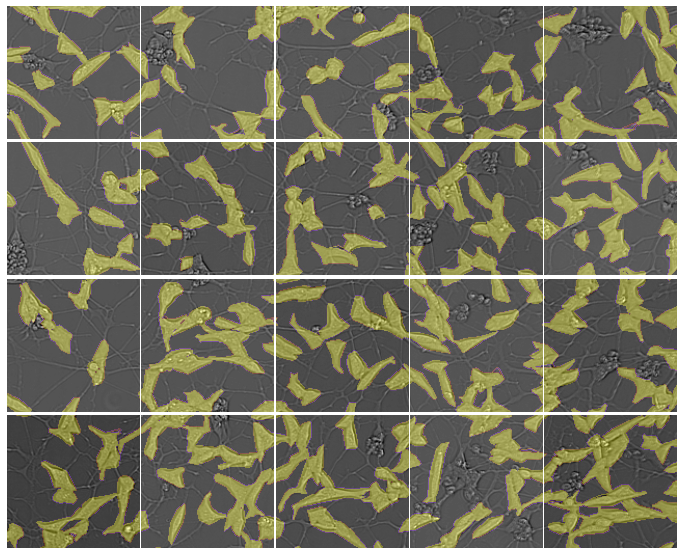

In [16]:
%%time

train_imgs = train_imgs.astype(np.uint16)[..., :1]

train_masks_box[..., 1] *= 0
train_masks_box = train_masks_box.astype(np.uint16)[..., :1]

train_imgs = np.concatenate([split_img(train_imgs[i], excess=False) for i in range(len(train_imgs))], axis=0)
train_masks_box = np.concatenate([split_img(train_masks_box[i], excess=False) for i in range(len(train_masks_box))], axis=0)

print('train_imgs shape:', train_imgs.shape, "type:", train_imgs.dtype)
print('train_masks shape:', train_masks_box.shape, "type:", train_masks_box.dtype)

view_spliting_imgs(train_imgs, train_masks_box, excess=False)

## train & valid

Now split on train and valid samples.

In [17]:
split_by = len(train_imgs) // 10

train_imgs, valid_imgs = train_imgs[split_by:], train_imgs[:split_by]
train_masks_box, valid_masks_box = train_masks_box[split_by:], train_masks_box[:split_by]

print('train_imgs shape:', train_imgs.shape, "type:", train_imgs.dtype)
print('train_masks shape:', train_masks_box.shape, "type:", train_masks_box.dtype)

print('valid_imgs shape:', valid_imgs.shape, "type:", valid_imgs.dtype)
print('valid_masks shape:', valid_masks_box.shape, "type:", valid_masks_box.dtype)

train_imgs shape: (10908, 128, 128, 1) type: uint16
train_masks shape: (10908, 128, 128, 1) type: uint16
valid_imgs shape: (1212, 128, 128, 1) type: uint16
valid_masks shape: (1212, 128, 128, 1) type: uint16


Now load in datasets

In [18]:
%%time

train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_masks_box))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_masks_box))

print(train_ds)
print(valid_ds)

<TensorSliceDataset shapes: ((128, 128, 1), (128, 128, 1)), types: (tf.uint16, tf.uint16)>
<TensorSliceDataset shapes: ((128, 128, 1), (128, 128, 1)), types: (tf.uint16, tf.uint16)>
Wall time: 11.2 s


Preprocess datasets

In [19]:
def prep_data(img: np.ndarray, 
              mask: np.ndarray) -> tuple:
    """normalize pixel array -> retype pixel array
    
    params:
        img:  image array
        mask: mask array"""
    
    img = tf.cast(img / 255, tf.float32)
    mask = tf.cast(mask / 255, tf.float32)
    
    return img, mask

def pipline(ds, batch_size=1):
    """cache -> suffle -> preprocess -> split on batchs -> prefetch
    
    params:
        ds: dataset to pipline"""
    
    ds = ds.cache()
    ds = ds.shuffle(1000)
    ds = ds.map(prep_data)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

In [20]:
BATCH_SIZE = 1

train_ds = pipline(train_ds, BATCH_SIZE)
valid_ds = valid_ds.map(prep_data).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

<PrefetchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


# Model

In [21]:
class Downsample(tf.keras.Model):
    
    def __init__(self, filters):
        super().__init__()
        
        self.conv1 = layers.Conv2D(filters, (3, 3), padding="same")
        self.conv2 = layers.Conv2D(filters, (3, 3), padding="same")
        
    def call(self, x):
        
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        
        return x
    
class Upsample(tf.keras.Model):
    
    def __init__(self, filters):
        super().__init__()
        
        self.conv_trans = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same")
        self.conv1 = layers.Conv2D(filters, (3, 3), padding="same")
        self.conv2 = layers.Conv2D(filters, (3, 3), padding="same")
        
    def call(self, x, coat):
        
        x = tf.nn.relu(self.conv_trans(x))
        x = tf.concat([coat, x], axis=3)
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        
        return x

class Unet(tf.keras.Model):
    
    def __init__(self, outs=1):
        super().__init__()
        
        # ENCODER
        self.pool = layers.MaxPooling2D((2, 2), (2, 2), padding="same")
        
        self.encoder64  = Downsample(64)
        self.encoder128 = Downsample(128)
        self.encoder256 = Downsample(256)
        self.encoder512 = Downsample(512)
        self.encoder1024 = Downsample(1024)
        
        self.encoder2048 = Downsample(2048)
        
        # DECODER
        self.decoder1024 = Upsample(1024)
        self.decoder512 = Upsample(512)
        self.decoder256 = Upsample(256)
        self.decoder128 = Upsample(128)
        self.decoder64  = Upsample(64)
        
        self.final = layers.Conv2D(outs, (3, 3), padding='same')
        
    def call(self, x):
        
        # ENCODER
        x1 = self.encoder64(x)
        x  = self.pool(x1)       # (128, 128, 1) -> (64, 64, 64)
        
        x2 = self.encoder128(x)
        x  = self.pool(x2)       # (64, 64, 64) -> (32, 32, 128)
        
        x3 = self.encoder256(x)
        x  = self.pool(x3)       # (32, 32, 128) -> (16, 16, 256)
        
        x4 = self.encoder512(x)
        x  = self.pool(x4)       # (16, 16, 256) -> (8, 8, 512)
        
        x = self.encoder1024(x)
        
        # DECODER
        x = self.decoder512(x, x4) # (8, 8, 512) -> (16, 16, 512)
        x = self.decoder256(x, x3) # (16, 16, 512) -> (32, 32, 256)
        x = self.decoder128(x, x2) # (32, 32, 256) -> (64, 64, 128)
        x = self.decoder64(x, x1)  # (64, 64, 128) -> (128, 128, 64)
    
        x = self.final(x)          # (128, 128, 64) -> (128, 128, 1)
        x = tf.nn.sigmoid(x)
        
        return x

## functions for training

In [22]:
def plot_process(train_values, valid_values=None, figsize=(16, 4), title=None):
    """plot loss or accuracy
    
    params:
        train_values: array for train
        valid_values: array for valid
        figsize:      size of plots"""
    
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.plot(train_values, label='train')
    if valid_values:
        plt.plot(valid_values, label='valid')
    plt.legend()
    plt.grid()
    plt.show()
    
def view_masks(img, mask, pred_mask, figsize=(14, 8)):
    """view result of training
    
    params:
        img:       array of original image
        mask:      array of original mask
        pred_mask: array of predicted mask
        figsize:   size of image"""
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    ax[0].set_title('true')
    ax[0].imshow(img, cmap='binary')
    ax[0].imshow(mask, cmap='gnuplot', alpha=0.3)

    ax[1].set_title('pred')
    ax[1].imshow(img, cmap='binary')
    ax[1].imshow(pred_mask, cmap='gnuplot', alpha=0.3)
    
    plt.show()

## variables for training

In [23]:
EPOCHS = 0

model = Unet(outs=1)
optimizer = tf.keras.optimizers.Adam()

loss = tf.losses.BinaryCrossentropy()
metric = tf.metrics.SparseCategoricalAccuracy()

train_losses, train_metrics = [], []
valid_losses, valid_metrics = [], []

valid_batch_imgs, valid_batch_masks = next(valid_ds.as_numpy_iterator())

## checkpoint

In [24]:
ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(
    checkpoint=ckpt, 
    directory="./checkpoints/trainUnet", 
    max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!')

Latest checkpoint restored!


## training

In [25]:
%%time

for epoch in range(EPOCHS):

    for i, (train_batch_imgs, train_batch_masks) in enumerate(train_ds):

        with tf.GradientTape() as tape:
            train_batch_masks_pred = model(train_batch_imgs)
            train_loss = loss(train_batch_masks, train_batch_masks_pred)

        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if i % 100 == 0:

            train_metric = metric(train_batch_masks, train_batch_masks_pred)

            train_losses.append(train_loss)
            train_metrics.append(train_metric)

            valid_batch_masks_pred = model(valid_batch_imgs)
            valid_loss = loss(valid_batch_masks, valid_batch_masks_pred)
            valid_metric = metric(valid_batch_masks, valid_batch_masks_pred)

            valid_losses.append(valid_loss)
            valid_metrics.append(valid_metric)

            print(f"{i}\ttrain binary: {train_loss:.4f} | train accuracy: {train_metric:.4f} |",
                  f"valid binary: {valid_loss:.4f} | valid accuracy: {valid_metric:.4f}")

        if i % 1000 == 0:
            display.clear_output(wait=False)
            
            print("epoch:", epoch+1)

            plot_process(train_losses, valid_losses, figsize=(16, 3), title="BCE")
            plot_process(train_metrics, valid_metrics, figsize=(16, 3), title="Accuracy")
            
            view_masks(
                img=valid_batch_imgs[0, ..., 0],
                mask=valid_batch_masks[0],
                pred_mask=(valid_batch_masks_pred[0] > 0.5).numpy().astype(np.float32), 
                figsize=(12, 8)
            )
            
            ckpt_manager.save()
            print("checkpoint was saved")

Wall time: 0 ns


# Test images

## get images

train file count: 606
dims of images: (3, 520, 704, 3)


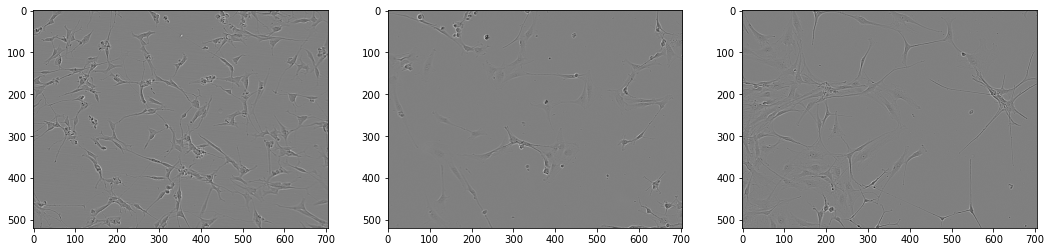

In [26]:
# get paths to images
paths_to_testing_imgs = get_full_path_list(PATH_TO_TEST_DIR)
print("train file count:", len(paths_to_training_imgs))

# get images
test_imgs = np.array([get_img(path) for path in paths_to_testing_imgs], dtype=np.uint)
print("dims of images:", test_imgs.shape)

# view images
view_examples(test_imgs)
plt.show()

## preprocess

(30, 128, 128, 1)


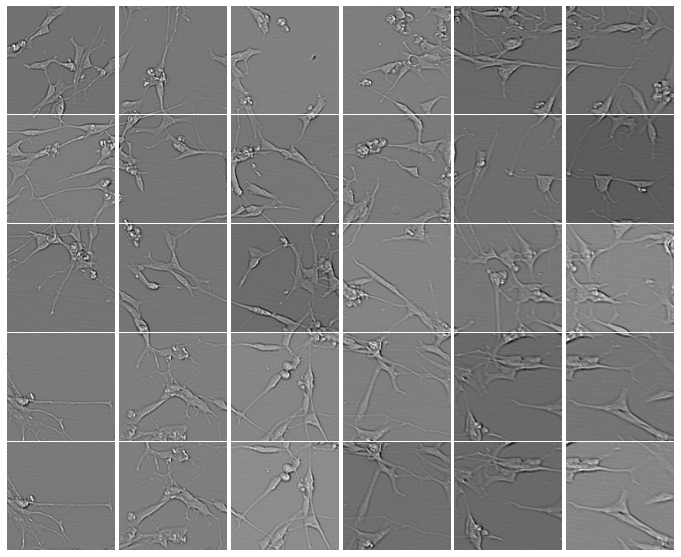

In [27]:
test_img0 = split_img(test_imgs[0, ..., :1], excess=True)
test_img1 = split_img(test_imgs[1, ..., :1], excess=True)
test_img2 = split_img(test_imgs[2, ..., :1], excess=True)

print(test_img0.shape)

view_spliting_imgs(test_img0, excess=True)

## predict

In [28]:
def prediction_test(img: np.ndarray,
                    batch: int = 4) -> np.ndarray:
    
    """predicts masks for image pieces
    
    params:
        img:   array of image pieces
        batch: number of images in batch"""
    
    batch_excess = len(img) % batch
    
    batch_count = len(img) // batch
    batch_count += 1 if batch_excess else 0
    
    test_mask_preds = []
    
    for i in range(batch_count):
        
        test_batch_mask_pred = model(img[i*batch: (i+1)*batch] / 255)
        test_batch_mask_pred = test_batch_mask_pred.numpy() > 0.5
        test_batch_mask_pred = test_batch_mask_pred.astype(np.uint)
        
        for mask in test_batch_mask_pred:
            test_mask_preds.append(mask)
            
    test_mask_preds = np.array(test_mask_preds)
    
    return test_mask_preds

(30, 128, 128, 1)


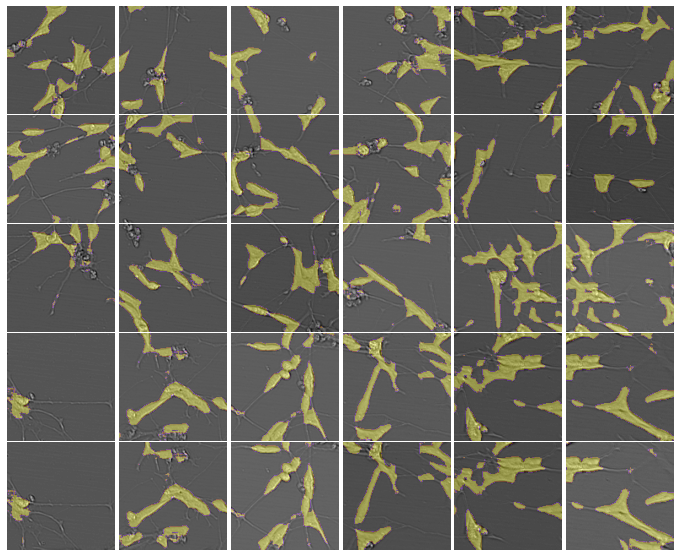

In [29]:
test_mask_preds0 = prediction_test(test_img0)

print(test_mask_preds0.shape)

view_spliting_imgs(test_img0, test_mask_preds0)

(30, 128, 128, 1)


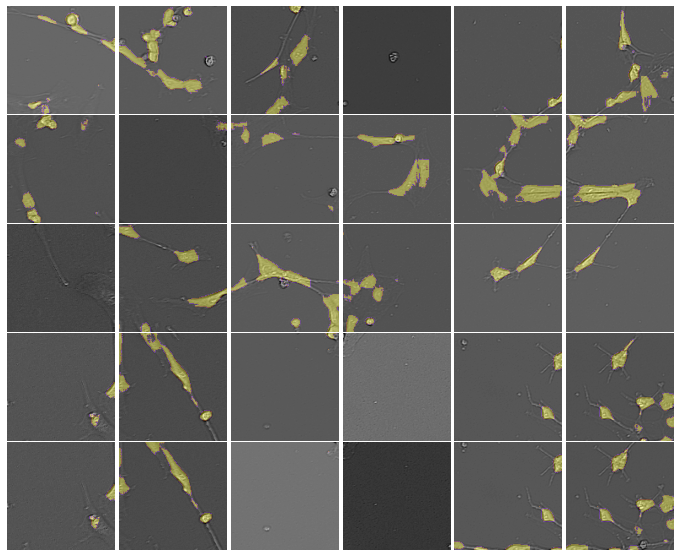

In [30]:
test_mask_preds1 = prediction_test(test_img1)

print(test_mask_preds1.shape)

view_spliting_imgs(test_img1, test_mask_preds1)

(30, 128, 128, 1)


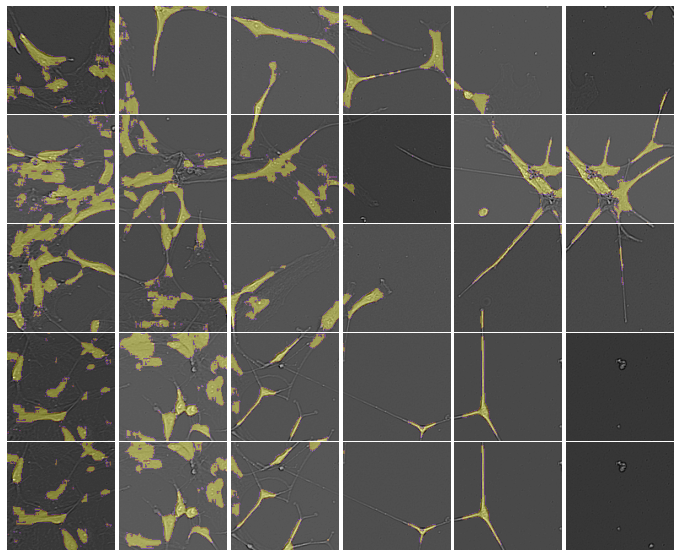

In [31]:
test_mask_preds2 = prediction_test(test_img2)

print(test_mask_preds2.shape)

view_spliting_imgs(test_img2, test_mask_preds2)

## concat result

In [32]:
def concat_img(pieces: np.ndarray):
    """Concatinate parts of image into original image
    
    params:
        pieces: array of images that are part of a original image"""
    
    size = pieces.shape[1] # 128
    
    w_excess = WIDTH % size
    h_excess = HEIGHT % size
    
    cols = WIDTH // size
    rows = HEIGHT // size
    
    cols += 1 if w_excess else 0
    rows += 1 if h_excess else 0
    
    result = []
    for i in range(rows):
    
        row = pieces[i*cols:(i+1)*cols]

        if w_excess:
            half1 = np.concatenate(row[:cols-1], axis=1)
            half2 = row[cols-1, :, size-w_excess:]
            row = np.concatenate([half1, half2], axis=1)
        
        if h_excess and i == rows-1:
            row = row[size-h_excess:]
        
        result.append(row)
        
    result = np.concatenate(result)
    
    return result

(520, 704) (520, 704)


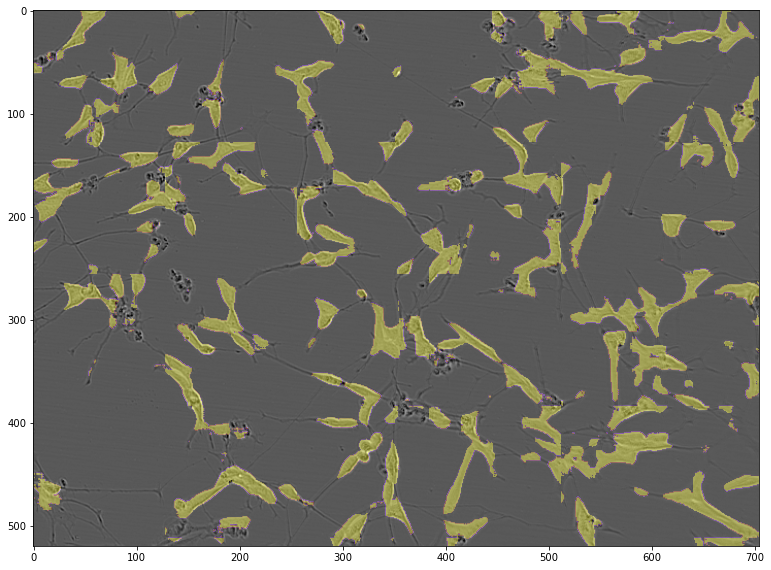

In [33]:
test_img0 = concat_img(test_img0[..., 0])
test_mask_preds0 = concat_img(test_mask_preds0[..., 0])

print(test_img0.shape, test_mask_preds0.shape)

plt.figure(figsize=(13, 11))
plt.imshow(test_img0, cmap="gray")
plt.imshow(test_mask_preds0, cmap="gnuplot", alpha=0.3)

(520, 704) (520, 704)


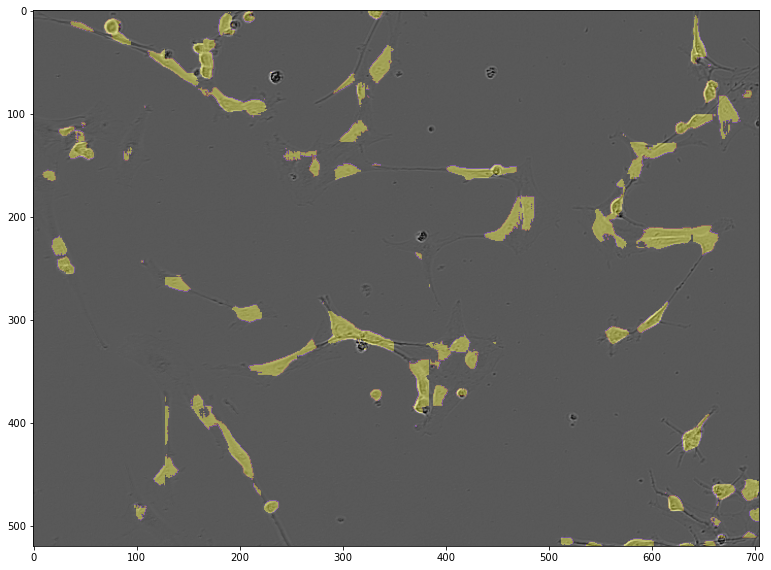

In [34]:
test_img1 = concat_img(test_img1[..., 0])
test_mask_preds1 = concat_img(test_mask_preds1[..., 0])

print(test_img1.shape, test_mask_preds1.shape)

plt.figure(figsize=(13, 11))
plt.imshow(test_img1, cmap="gray")
plt.imshow(test_mask_preds1, cmap="gnuplot", alpha=0.3)

(520, 704) (520, 704)


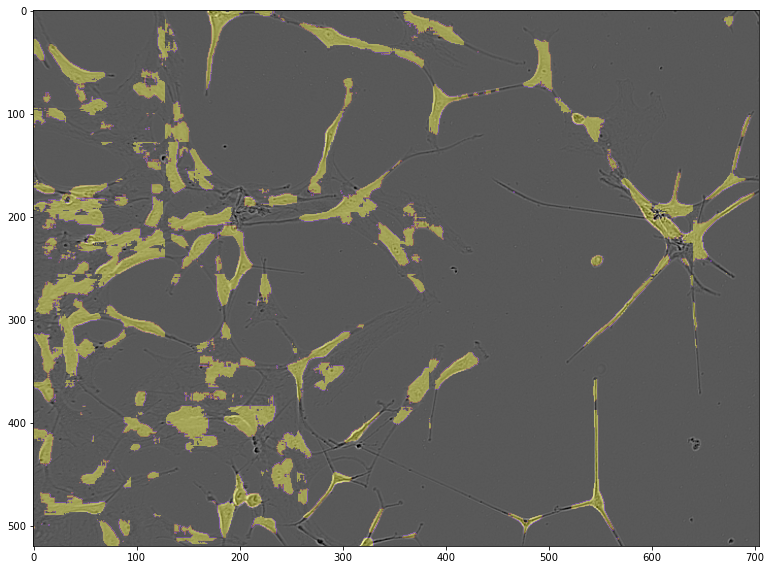

In [35]:
test_img2 = concat_img(test_img2[..., 0])
test_mask_preds2 = concat_img(test_mask_preds2[..., 0])

print(test_img2.shape, test_mask_preds2.shape)

plt.figure(figsize=(13, 11))
plt.imshow(test_img2, cmap="gray")
plt.imshow(test_mask_preds2, cmap="gnuplot", alpha=0.3)

# Object detector

In [37]:
def to_rgb(img):
    
    img = img[..., None]
    img = np.concatenate([img, img, img], axis=-1)
    
    return img

def concat_img_mask(img, mask):
    
    mask = np.ones_like(mask) - mask
    img[..., 0] = img[..., 0] * mask
    
    return img

(<Figure size 1296x288 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

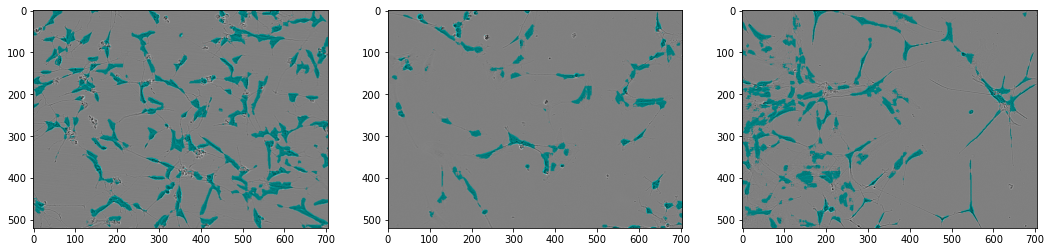

In [38]:
test_img0 = to_rgb(test_img0)
test_img1 = to_rgb(test_img1)
test_img2 = to_rgb(test_img2)

test_img_mask0 = concat_img_mask(test_img0, test_mask_preds0)
test_img_mask1 = concat_img_mask(test_img1, test_mask_preds1)
test_img_mask2 = concat_img_mask(test_img2, test_mask_preds2)

view_examples([test_img_mask0, test_img_mask1, test_img_mask2])

# boxes (test)

In [36]:
%%time

URL_TO_MODEL = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(URL_TO_MODEL).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Wall time: 1min 33s


In [42]:
convert_img0 = tf.constant(test_img_mask0.astype(np.float32) / 255)[None]

result = detector(convert_img0)
result = {key: value.numpy() for key, value in result.items()}
result.keys()

dict_keys(['detection_boxes', 'detection_class_labels', 'detection_class_names', 'detection_scores', 'detection_class_entities'])

In [58]:
image       = test_img_mask0
boxes       = result["detection_boxes"]
class_names = result["detection_class_entities"]
scores      = result["detection_scores"]

In [50]:
ymin, xmin, ymax, xmax = boxes[1]
ymin, xmin, ymax, xmax

(0.0019833373, 0.010995837, 0.97647136, 0.7835277)

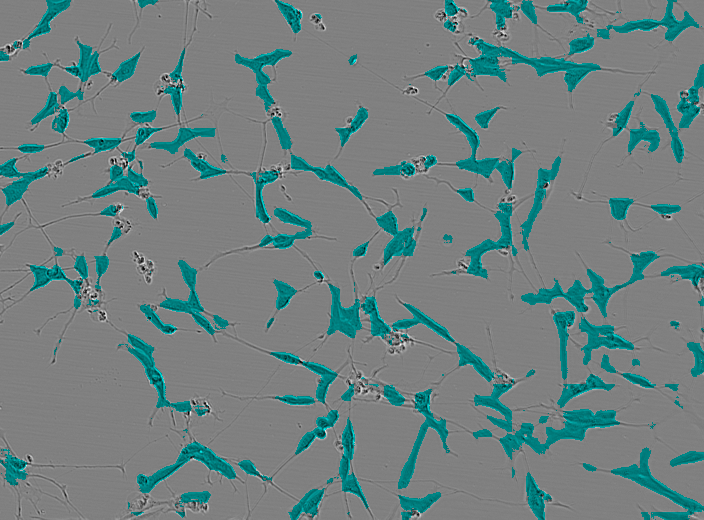

In [59]:
image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
image_pil

In [60]:
draw = ImageDraw.Draw(image_pil)
im_width, im_height = image_pil.size
(left, right, top, bottom) = (xmin * im_width,  xmax * im_width, 
                              ymin * im_height, ymax * im_height)

In [61]:
draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)])

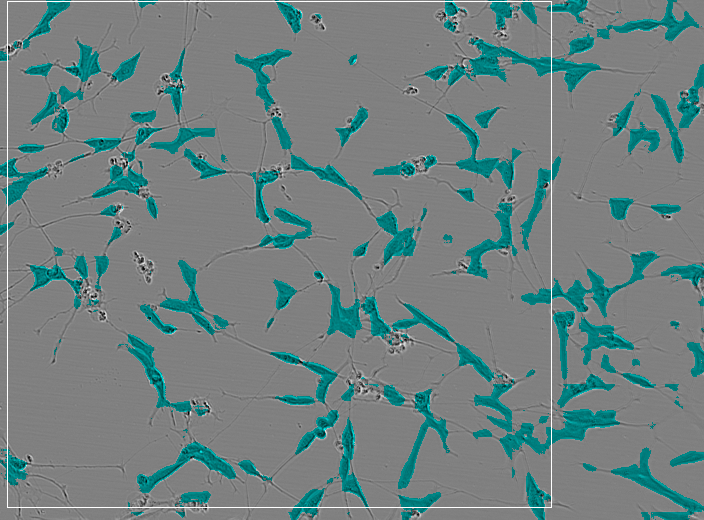

In [62]:
image_pil